In [3]:
# ================================
# Suppress warnings (clean logs)
# ================================
import warnings
warnings.filterwarnings("ignore")

# ================================
# Core libraries
# ================================
import cv2                  # Image processing (OpenCV)
import numpy as np          # Numerical operations
import tensorflow as tf     # Deep learning framework
import tensorflow_hub as hub  # Load pretrained models (MoveNet)
import urllib.request       # Download images from URLs
import matplotlib.pyplot as plt  # Visualization
import os                   # File & path handling
import pandas as pd         # Data manipulation
import joblib               # Model persistence (save/load)
from datetime import datetime  # Timestamps

# ================================
# ML utilities
# ================================
from sklearn.model_selection import train_test_split  # Train/test split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import lightgbm as lgb      # Gradient boosting model

# ================================
# Custom pose / angle logic
# ================================
import importlib
import image_angle_func   # Your custom image pose module
importlib.reload(image_angle_func)  # Reload to pick up changes
from image_angle_func import *      # Import helper functions

In [138]:
# ================================
# Read input data from Excel
# ================================
input_df_final = pd.read_excel('Final_Input_File.xlsx')

# ==========================================
# Remove ambiguous / unusable angle labels
# (Keep only confidently labeled angles)
# ==========================================
input_df_final = (
    input_df_final[
        ~input_df_final['true_angle'].isin(['OTHER', 'UNSURE'])
    ]
    .reset_index(drop=True)
)

# ==========================================
# Remove duplicate images
# - Deduplicate using image_url
# - Keep the latest occurrence
# ==========================================
input_df_final_clean = (
    input_df_final
    .drop_duplicates(subset=["image_url"], keep="last")
)

In [142]:
# ==========================================
# Run MoveNet pose detection in parallel
# ==========================================
output_df = run_movenet_multithread(
    input_df_final_clean,   # Cleaned input dataframe
    url_col="image_url",    # Column containing image URLs
    max_workers=7,          # Number of parallel threads (CPU/network bound)
    timeout=15              # Max wait time per image (seconds)
)

# ==========================================
# Persist pose extraction results
# ==========================================
save_outputs(output_df)

Processing: 100%|████████████████████████████████████████████████████████████████████| 300/300 [01:07<00:00,  4.46it/s]

Saved files:
 → movenet_output_18012026101350.parquet


In [143]:
# ==========================================
# Generate CLIP image embeddings
# ==========================================
clip_embeddings = run_clip_on_df(
    input_df_final_clean,   # Input dataframe with image URLs
    url_col="image_url",    # Column containing image URLs
    max_workers=7,          # Keep low to avoid GPU/CPU memory pressure (torch)
)

# ==========================================
# Note:
# - clip_embeddings contains vector representations per image
# - These embeddings are later merged with pose outputs (output_df)
# ==========================================

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:33<00:00,  3.19it/s]


In [160]:
from sklearn.decomposition import PCA

# ==========================================
# Dimensionality reduction for CLIP embeddings
# ==========================================
pca_vars = 32                              # Number of PCA components to retain
pca = PCA(n_components=pca_vars, random_state=42)

# Fit PCA on CLIP embeddings and transform
clip_pca = pca.fit_transform(clip_embeddings)

# Persist PCA model for reuse during inference
joblib.dump(pca, "pca_clip.pkl")

# ==========================================
# Convert PCA output to DataFrame
# ==========================================
clip_pca_df = pd.DataFrame(
    clip_pca,
    columns=[f"clip_pca_{i}" for i in range(pca_vars)]
)

# Attach metadata for traceability
clip_pca_df["url"] = input_df_final_clean["image_url"].values
clip_pca_df["true_angle"] = input_df_final_clean["true_angle"]

# ==========================================
# Save PCA-transformed embeddings
# ==========================================
save_outputs(clip_pca_df, "clip_pca_df")

Saved files:
 → clip_pca_df_18012026101540.parquet


In [162]:
# ==========================================
# Merge pose features with CLIP PCA features
# ==========================================
final_df = output_df.merge(
    clip_pca_df,    # CLIP PCA embeddings
    on="url",       # Common join key (image URL)
    how="left"      # Preserve all pose rows
)

In [164]:
# ==========================================
# Build final model-ready feature dataframe
# ==========================================
feature_df = build_final_feature_df(
    final_df     # Combined pose + CLIP feature dataset
)

In [166]:
# ==========================================
# Attach labels / metadata back to features
# ==========================================
train_test_data = feature_df.merge(
    final_df,       # Source containing labels & additional metadata
    left_on="url",  # Join key from feature dataframe
    right_on="url", # Join key from final dataframe
    how="left"      # Preserve all feature rows
)

In [168]:
# ==========================================
# Filter rows with valid target labels
# ==========================================
model_df = (
    train_test_data[
        train_test_data["true_angle"].notna()
    ]
    .copy()
)

# Inspect dataset shape after filtering
model_df.shape

# Check class distribution of target variable
model_df["true_angle"].value_counts()

true_angle
Back        236
B-tilted     48
F-tilted     10
Front         3
Side          3
Name: count, dtype: int64

In [170]:
# ==========================================
# Define non-feature (metadata / label) columns
# ==========================================
NON_FEATURE_COLS = ["url", "true_angle"]

# ==========================================
# Split features and target label
# ==========================================
X = model_df.drop(columns=NON_FEATURE_COLS)  # Model input features
y = model_df["true_angle"]                   # Target variable

# Sanity check on dimensions
print(X.shape, y.shape)

(300, 187) (300,)


In [172]:
# ==========================================
# Split data into training and test sets
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X,                  # Feature matrix
    y,                  # Target labels
    test_size=0.2,      # 20% data reserved for testing
    random_state=42,    # Reproducibility
    stratify=y          # Preserve class distribution
)

# ==========================================
# Verify class balance after split
# ==========================================
print(y_train.value_counts(normalize=True))  # Train distribution
print(y_test.value_counts(normalize=True))   # Test distribution

true_angle
Back        0.787500
B-tilted    0.158333
F-tilted    0.033333
Side        0.012500
Front       0.008333
Name: proportion, dtype: float64
true_angle
Back        0.783333
B-tilted    0.166667
F-tilted    0.033333
Front       0.016667
Name: proportion, dtype: float64


In [174]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==========================================
# Initialize LightGBM multiclass classifier
# ==========================================
model = lgb.LGBMClassifier(
    objective="multiclass",      # Multiclass classification objective
    num_class=y_train.nunique(), # Number of unique angle classes
    random_state=42,             # Reproducibility
    n_estimators=200,            # Number of boosting rounds
    learning_rate=0.05,          # Step size shrinkage
    verbosity=-1                 # Silence training logs
)

# ==========================================
# Train model on training data
# ==========================================
model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, n_estimators=200, num_class=5,
               objective='multiclass', random_state=42, verbosity=-1)

In [176]:
# ==========================================
# Generate predictions on test set
# ==========================================
y_pred = model.predict(X_test)

# ==========================================
# Get class probability scores
# (useful for confidence / thresholding)
# ==========================================
y_prob = model.predict_proba(X_test)

# ==========================================
# Evaluate model performance
# ==========================================
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

    B-tilted       1.00      0.40      0.57        10
        Back       0.85      1.00      0.92        47
    F-tilted       0.00      0.00      0.00         2
       Front       0.00      0.00      0.00         1

    accuracy                           0.85        60
   macro avg       0.46      0.35      0.37        60
weighted avg       0.84      0.85      0.82        60


Confusion Matrix:
 [[ 4  6  0  0]
 [ 0 47  0  0]
 [ 0  1  0  1]
 [ 0  1  0  0]]


In [39]:
import joblib
# ==========================================
# Persist trained LightGBM model to disk
# ==========================================
joblib.dump(model, "lgb_pose_model.pkl")

['lgb_pose_model_14012026.pkl']

In [182]:
# ==========================================
# Define consistent class label order
# ==========================================
labels = sorted(y_test.unique())   # Ensures stable row/column ordering

# ==========================================
# Compute confusion matrix using fixed labels
# ==========================================
cm = confusion_matrix(
    y_test,
    y_pred,
    labels=labels
)

# ==========================================
# Convert confusion matrix to labeled DataFrame
# ==========================================
cm_df = pd.DataFrame(
    cm,
    index=[f"Actual_{l}" for l in labels],   # Rows = true labels
    columns=[f"Pred_{l}" for l in labels]    # Columns = predicted labels
)
cm_df.head(10)

,Pred_B-tilted,Pred_Back,Pred_F-tilted,Pred_Front
Actual_B-tilted,4,6,0,0
Actual_Back,0,47,0,0
Actual_F-tilted,0,1,0,1
Actual_Front,0,1,0,0


In [184]:
# ==========================================
# Generate predictions on test set
# ==========================================
y_pred = model.predict(X_test)

# ==========================================
# Get prediction probability distribution
# ==========================================
y_prob = model.predict_proba(X_test)

# ==========================================
# Create inspection dataframe for analysis
# ==========================================
inspect_df = X_test.copy()

# Attach ground truth and predictions
inspect_df["true_angle"] = y_test.values
inspect_df["pred_angle"] = y_pred

# Store model confidence (max class probability)
inspect_df["pred_conf"] = y_prob.max(axis=1)

# ==========================================
# Identify misclassified samples
# ==========================================
disagree_df = (
    inspect_df[
        inspect_df["true_angle"] != inspect_df["pred_angle"]
    ]
    .copy()
)

# Attach image URLs for manual inspection
disagree_df["url"] = model_df.loc[disagree_df.index, "url"]

# Display key columns for review
disagree_df[["url", "true_angle", "pred_angle", "pred_conf"]]
disagree_df.head(5)

,shoulder_width,hip_width,torso_length,shoulder_angle,hip_angle,torso_angle,left_arm_length,right_arm_length,left_leg_length,right_leg_length,shoulder_hip_ratio,arm_symmetry,leg_symmetry,shoulder_torso_ratio,hip_torso_ratio,body_center_x,body_center_y,visibility_face_score,visible_keypoints,visible_face_keypoints,visible_upper_body,visible_lower_body,vertical_span,lowest_visible_joint,torso_dx,torso_dx_norm,mean_upper_conf,mean_lower_conf,conf_upper_minus_lower,pose_completeness,shoulder_hip_angle_diff,upper_lr_conf_imbalance,lower_lr_conf_imbalance,width_collapse_ratio,torso_vector_angle,nose_x_x,nose_y_x,nose_conf_x,vis_nose,left_eye_x_x,left_eye_y_x,left_eye_conf_x,vis_left_eye,right_eye_x_x,right_eye_y_x,right_eye_conf_x,vis_right_eye,left_ear_x_x,left_ear_y_x,left_ear_conf_x,vis_left_ear,right_ear_x_x,right_ear_y_x,right_ear_conf_x,vis_right_ear,left_shoulder_x_x,left_shoulder_y_x,left_shoulder_conf_x,vis_left_shoulder,right_shoulder_x_x,right_shoulder_y_x,right_shoulder_conf_x,vis_right_shoulder,left_elbow_x_x,left_elbow_y_x,left_elbow_conf_x,vis_left_elbow,right_elbow_x_x,right_elbow_y_x,right_elbow_conf_x,vis_right_elbow,left_wrist_x_x,left_wrist_y_x,left_wrist_conf_x,vis_left_wrist,right_wrist_x_x,right_wrist_y_x,right_wrist_conf_x,vis_right_wrist,left_hip_x_x,left_hip_y_x,left_hip_conf_x,vis_left_hip,right_hip_x_x,right_hip_y_x,right_hip_conf_x,vis_right_hip,left_knee_x_x,left_knee_y_x,left_knee_conf_x,vis_left_knee,right_knee_x_x,right_knee_y_x,right_knee_conf_x,vis_right_knee,left_ankle_x_x,left_ankle_y_x,left_ankle_conf_x,vis_left_ankle,right_ankle_x_x,right_ankle_y_x,right_ankle_conf_x,vis_right_ankle,nose_x_y,nose_y_y,nose_conf_y,left_eye_x_y,left_eye_y_y,left_eye_conf_y,right_eye_x_y,right_eye_y_y,right_eye_conf_y,left_ear_x_y,left_ear_y_y,left_ear_conf_y,right_ear_x_y,right_ear_y_y,right_ear_conf_y,left_shoulder_x_y,left_shoulder_y_y,left_shoulder_conf_y,right_shoulder_x_y,right_shoulder_y_y,right_shoulder_conf_y,left_elbow_x_y,left_elbow_y_y,left_elbow_conf_y,right_elbow_x_y,right_elbow_y_y,right_elbow_conf_y,left_wrist_x_y,left_wrist_y_y,left_wrist_conf_y,right_wrist_x_y,right_wrist_y_y,right_wrist_conf_y,left_hip_x_y,left_hip_y_y,left_hip_conf_y,right_hip_x_y,right_hip_y_y,right_hip_conf_y,left_knee_x_y,left_knee_y_y,left_knee_conf_y,right_knee_x_y,right_knee_y_y,right_knee_conf_y,left_ankle_x_y,left_ankle_y_y,left_ankle_conf_y,right_ankle_x_y,right_ankle_y_y,right_ankle_conf_y,success,clip_pca_0,clip_pca_1,clip_pca_2,clip_pca_3,clip_pca_4,clip_pca_5,clip_pca_6,clip_pca_7,clip_pca_8,clip_pca_9,clip_pca_10,clip_pca_11,clip_pca_12,clip_pca_13,clip_pca_14,clip_pca_15,clip_pca_16,clip_pca_17,clip_pca_18,clip_pca_19,clip_pca_20,clip_pca_21,clip_pca_22,clip_pca_23,clip_pca_24,clip_pca_25,clip_pca_26,clip_pca_27,clip_pca_28,clip_pca_29,clip_pca_30,clip_pca_31,true_angle,pred_angle,pred_conf,url
79,0.091127,0.002039,0.182316,-78.333089,4.283631,33.173478,0.431971,0.270952,0.753273,0.759245,44.695153,1.594273,0.992133,0.499830,0.011183,0.351558,0.514116,0.019864,5,0,3,2,0.367743,3,-0.152602,-1.674604,0.271939,0.285339,-0.013399,0.294118,82.616719,0.136362,0.341718,44.673242,-2.562606,-0.007481,0.509308,0.021138,False,-0.006690,0.514427,0.017051,False,0.001747,0.509243,0.037515,False,0.017886,0.072497,0.009603,False,-0.009499,0.417462,0.014012,False,-0.028988,0.480998,0.025007,False,-0.010560,0.391753,0.039698,False,0.053365,0.703256,0.490455,True,0.046615,0.335513,0.446710,True,0.241807,0.753192,0.232175,False,0.236949,0.348124,0.397592,True,0.131811,0.536058,0.243087,False,0.133844,0.536210,0.251613,False,0.539249,0.588978,0.308271,True,0.533788,0.534879,0.162218,False,0.881613,0.594710,0.475516,True,0.889324,0.586743,0.271325,False,-0.007481,0.509308,0.021138,-0.006690,0.514427,0.017051,0.001747,0.509243,0.037515,0.017886,0.072497,0.009603,-0.009499,0.417462,0.014012,-0.028988,0.480998,0.025007,-0.010560,0.391753,0.039698,0.053365,0.703256,0.490455,0.046615,0.335513,0.446710,0.241807,0.753192,0.232175,0.236949,0.3

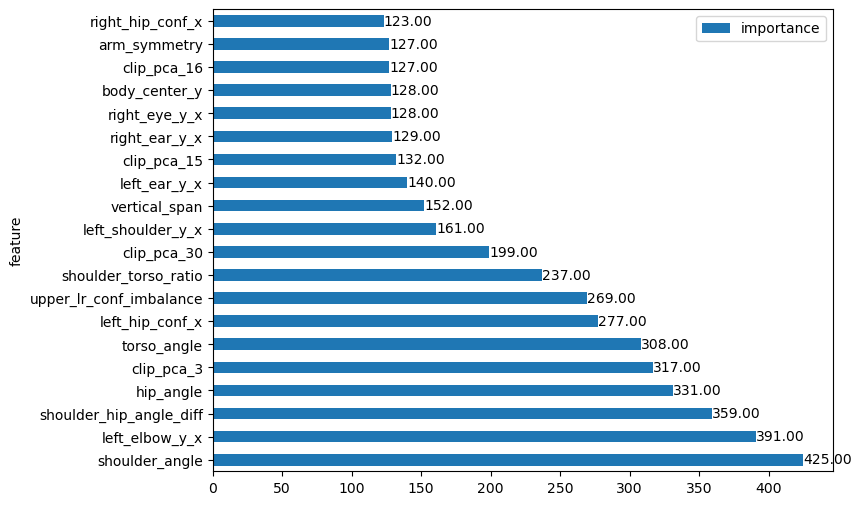

In [186]:
# ==========================================
# Extract feature importances from the model
# ==========================================
feat_imp = (
    pd.DataFrame({
        "feature": X_train.columns,                 # Feature names
        "importance": model.feature_importances_    # Importance scores
    })
    .sort_values("importance", ascending=False)
)

# Save feature importances for offline analysis
feat_imp.to_csv("feature_imps.csv", index=False)

# ==========================================
# Visualize top 20 most important features
# ==========================================
ax = feat_imp.head(20).plot(
    x="feature",
    y="importance",
    kind="barh",
    figsize=(8, 6)
)

# Annotate bars with importance values
for p in ax.patches:
    ax.text(
        p.get_width(),                              # X-position (bar length)
        p.get_y() + p.get_height() / 2,            # Center of bar
        f"{p.get_width():.2f}",                    # Importance value
        va="center"
    )
